# Integrating an asteroid
---

This notebook demonstrates how you can use `jorbit` to integrate an asteroid's motion through the solar system. Beginning with a position/velocity from JPL Horizons, we'll compare how well `jorbit` matches Horizons' predictions for later times. After that, we'll run "out-and-back" tests to check the integrator's self consistency.

Like all `jorbit` examples, we'll be using `jax.numpy` instead of `numpy`. There is functionally no difference between the two in this case, but it follows our practice to use it wherever possible.

In [1]:
import jax
from jax.config import config

# very important- otherwise, JAX will use 32-bit floats by default
config.update("jax_enable_x64", True)

# optional but useful for debugging- will raise an error if any nans appear
config.update("jax_debug_nans", True)

import jax.numpy as jnp
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', module='erfa')

### Comparison with Horizons
---
First, we'll grab state vectors and astrometry from Horizons for a Main Belt Asteroid, (274301) Wikipedia. We'll consider a 10-year period starting on 2023-01-01.

In [2]:
times = Time(
    jnp.linspace(Time("2023-01-01").jd, Time("2033-01-01").jd, 30), format="jd"
)

# The state vectors:
####################
target = 274301  # MBA (274301) Wikipedia
horizons_query = Horizons(
    id=target,
    location="500@0",  # set the vector origin to the solar system barycenter
    epochs=[t.tdb.jd for t in times],
)

horizons_vectors = horizons_query.vectors(
    refplane="earth"
)  # the refplane argument gives us ICRS-alinged vectors
true_x0 = jnp.array(
    [horizons_vectors[0]["x"], horizons_vectors[0]["y"], horizons_vectors[0]["z"]]
)
true_v0 = jnp.array(
    [horizons_vectors[0]["vx"], horizons_vectors[0]["vy"], horizons_vectors[0]["vz"]]
)

horizons_vecs = jnp.column_stack(
    (
        horizons_vectors["x"].data.filled(),
        horizons_vectors["y"].data.filled(),
        horizons_vectors["z"].data.filled(),
    )
)

# The astrometry:
#################
horizons_query = Horizons(
    id=target,
    location="695@399",  # set the observer location to Kitt Peak
    epochs=[t.jd for t in times],
)  # astroquery takes in tdb for vector queries, but utc for ephemerides
horizons_astrometry = horizons_query.ephemerides(extra_precision=True)
horizons_coords = jnp.column_stack(
    (horizons_astrometry["RA"].data.filled(), horizons_astrometry["DEC"].data.filled())
)

print(horizons_vectors[:3].to_pandas())  # display the first few rows

                     targetname   datetime_jd                    datetime_str  \
0  274301 Wikipedia (2008 QH24)  2.459946e+06  A.D. 2023-Jan-01 00:01:09.1839   
1  274301 Wikipedia (2008 QH24)  2.460071e+06  A.D. 2023-May-06 23:11:29.8751   
2  274301 Wikipedia (2008 QH24)  2.460197e+06  A.D. 2023-Sep-09 22:21:50.5618   

       H     G         x         y         z        vx        vy        vz  \
0  16.97  0.15  0.732915 -1.855040 -0.551633  0.011515  0.005097  0.001612   
1  16.97  0.15  1.859779 -0.786546 -0.222768  0.005505  0.011137  0.003383   
2  16.97  0.15  2.019454  0.698184  0.224199 -0.002844  0.011412  0.003406   

   lighttime     range  range_rate  
0   0.011952  2.069453   -0.000920  
1   0.011733  2.031516    0.000357  
2   0.012409  2.148469    0.001390  


First, let's create a `Particle` object from `jorbit`. `Particle`s, as their name imply, deal with individual particles in a given dynamical system. They can either be tracer particles, or have their own masses. They both contain information about the current state of the particles (its cartesian state, instantaneous orbital elements, name, etc), and information about which of these parameters can vary when we fit it to data.

In [3]:
from jorbit import Particle

asteroid = Particle(
    x=true_x0,
    v=true_v0,
    gm=0,
    time=times[0],
    name='(274301) Wikipedia',
    )

Under the hood, `Particles` compute and store the conversion between cartesian state vectors and orbital elements. We can see these elements like this:

In [4]:
asteroid.elements

{'a': Array([2.38093163], dtype=float64),
 'ecc': Array([0.14645717], dtype=float64),
 'nu': Array([327.88590894], dtype=float64),
 'inc': Array([6.73266374], dtype=float64),
 'Omega': Array([183.35304211], dtype=float64),
 'omega': Array([139.75995282], dtype=float64)}

We also could have created the `Particle` using a dictionary of elements in the first place:

In [5]:
elements = asteroid.elements

asteroid2 = Particle(
    elements=elements,
    gm=0,
    time=times[0],
)

jnp.isclose(asteroid.x, asteroid2.x).all()

Array(True, dtype=bool)

To actually propagate the particle through time, we have to include it in a `System`. These are objects are built out of one or more `Particles`, but can then evolve them together under the influence of perturbing planets/each other, if any have a nonzero mass.

For now though, we'll only consider our single main belt asteroids and keep all of the default perturbers. This means that we can propagate the system between 1980 and 2100, and that it will account for the gravitational influence of all planets, Pluto, and the 16 most massive asteroids.

In [6]:
from jorbit import System

system = System(particles=[asteroid])

Let's propagate the system to each of the times for which we have Horizons data. Since the goal is to access the accuracy of the integration with respect to Horizons, we'll use all the corrections at our disposal and toggle the `use_GR` option to `True`. The tells `jorbit` to use a Parameterized Post Newtonian formulation when computing the acceleration caused by the sun and planets.

Note- here for the first time we see a quirk that `jorbit` inherits from `jax`. This whole scheme is only feasible in Python thanks to `jax's` use of "Just-in-time" compilation. A side effect of this compilation is that the first time we run something, it will take much longer than subsequent times. 

`jax` is very particular about what will trigger a recompilation. Although we've tried to hide most of these complications in the `jorbit.engine` functions, if you are running into long runtimes, excessive recompilation is likely the cause. See [🔪 JAX - The Sharp Bits 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) for more.

In [7]:
xs, vs = system.propagate(times, use_GR=True)

# Here we'll compare the 3D barycentric position to the Horizons predictions
discrepency = jnp.linalg.norm(xs - horizons_vecs, axis=1) * u.au.to(u.km)

Now we can plot the discrepency over time:

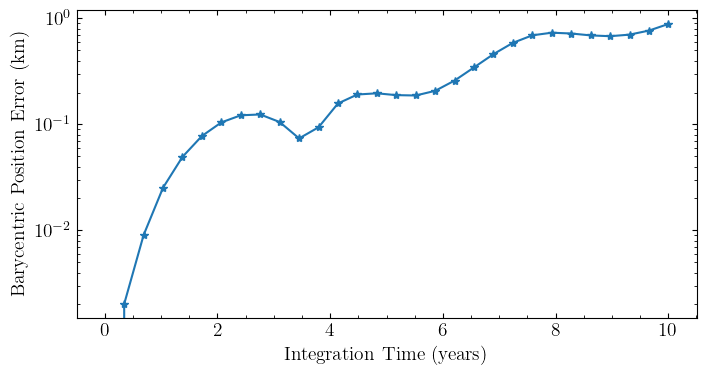

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((times.tdb.jd - times.tdb.jd[0])*u.day.to(u.year), discrepency, marker='*')
ax.set(yscale='log', xlabel='Integration Time (years)', ylabel='Barycentric Position Error (km)');

Although the error rises rapidly in the early times of an integration, note that after 10 years (several orbital periods of this main belt asteroid) our position estimate is still within 1km of the Horizons predictions. Putting that in context, we can convert each of these cartesian positions to positions on-sky, then compare how the astrometry compares to the Horizons positions:

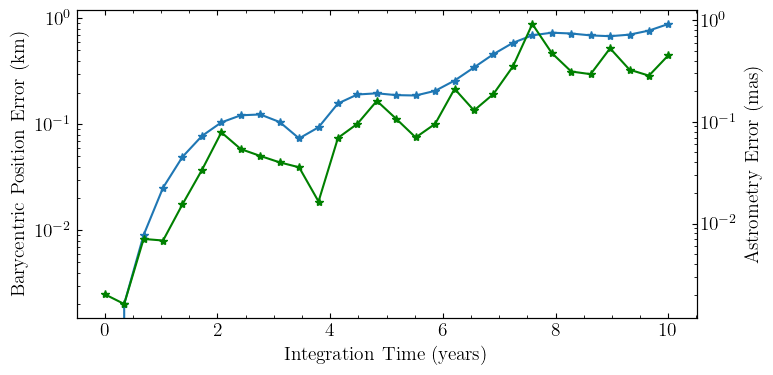

In [9]:
system = System(particles=[asteroid])

xs, vs, sky_coordinates = system.propagate(
    times, use_GR=True, sky_positions=True, observatory_locations="kitt peak"
)

# Can use astropy's SkyCoord class, or jorbit's api sky_error
astrometry_errors = (
    SkyCoord(list(horizons_coords), unit="deg")
    .separation(SkyCoord(sky_coordinates, unit="deg"))
    .mas
)


fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot((times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year), discrepency, marker="*")
ax1.set(
    yscale="log",
    xlabel="Integration Time (years)",
    ylabel="Barycentric Position Error (km)",
)

ax2 = ax1.twinx()
ax2.plot(
    (times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year),
    astrometry_errors,
    marker="*",
    color="g",
)

ax2.set(yscale="log", ylabel="Astrometry Error (mas)");

To further contextualize the astrometric accuracy, we can compare our integrated values to Horizon's uncertainty in its own RA and Dec positions:

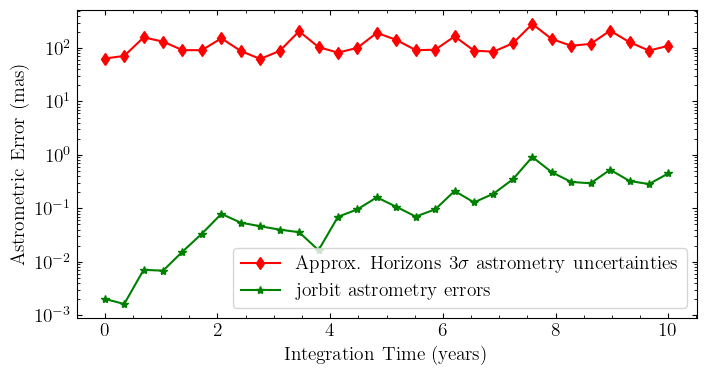

In [10]:
# Horizon's astrometry comes with 3 sigma uncertainties in arcseconds
uncertainties = jnp.linalg.norm(
    jnp.array(horizons_astrometry[["RA_3sigma", "DEC_3sigma"]].to_pandas().values),
    axis=1,
) * u.arcsec.to(u.mas)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    (times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year),
    uncertainties,
    marker="d",
    label="Approx. Horizons 3$\sigma$ astrometry uncertainties",
    color="r",
)

ax.plot(
    (times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year),
    astrometry_errors,
    marker="*",
    label="jorbit astrometry errors",
    color="g",
)
ax.legend()
ax.set(
    yscale="log",
    xlabel="Integration Time (years)",
    ylabel="Astrometric Error (mas)",
);

So, over $\sim$ decade long timescales, the astrometric error accumulated using jorbit stays below 1% of the 3$\sigma$ uncertainties in Horizon's positions.

For fun and to demonstrate `jorbit`'s ability to handle astrometric data from multiple observatories, let's compare the astrometric errors if we erroneously used Palomar instead of Kitt Peak as our location for the second half of the data:

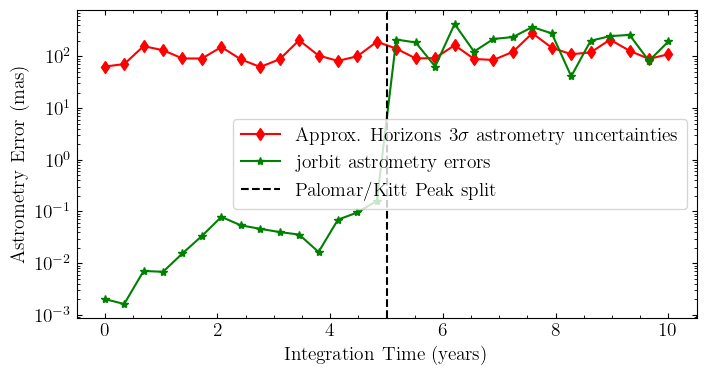

In [11]:
system = System(particles=[asteroid])

xs, vs, sky_coordinates = system.propagate(
    times,
    use_GR=True,
    sky_positions=True,
    observatory_locations=["kitt peak"] * 15 + ["palomar"] * 15,
)

# Can use astropy's SkyCoord class, or jorbit's api sky_error
astrometry_errors = (
    SkyCoord(list(horizons_coords), unit="deg")
    .separation(SkyCoord(sky_coordinates, unit="deg"))
    .mas
)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    (times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year),
    uncertainties,
    marker="d",
    label="Approx. Horizons 3$\sigma$ astrometry uncertainties",
    color="r",
)

ax.plot(
    (times.tdb.jd - times.tdb.jd[0]) * u.day.to(u.year),
    astrometry_errors,
    marker="*",
    label="jorbit astrometry errors",
    color="g",
)

ax.axvline(
    (times.tdb.jd[-1] - times.tdb.jd[0]) / 2 * u.day.to(u.year),
    color="k",
    linestyle="--",
    label="Palomar/Kitt Peak split",
)
ax.set(yscale="log", ylabel="Astrometry Error (mas)", xlabel="Integration Time (years)")
ax.legend();

### Comparison with ASSIST

Now, for the first time but certainly not last time, we can compare `jorbit` to `ASSIST` [Holman et al. 2023](https://ui.adsabs.harvard.edu/abs/2023PSJ.....4...69H/abstract). This is a wonderful and highly complementary package that set out to solve several of the same problems `jorbit` was designed to tackle, including orbit integration within the solar system. Built within the `REBOUND` ecosystem ([Rein and Liu 2011](https://ui.adsabs.harvard.edu/abs/2012A%26A...537A.128R/abstract)), `ASSIST` also uses the JPL DE-series ephemeredies to handle the motion of perturbing planets. Although `ASSIST` and `jorbit` share similar aims, there is no shared code between them (they're also written in entirely different languages under the hood), meaning they can be used to sanity check one another.

Below, we perform the same integration using `ASSIST`, then compare both integrators to the Horizons predictions.

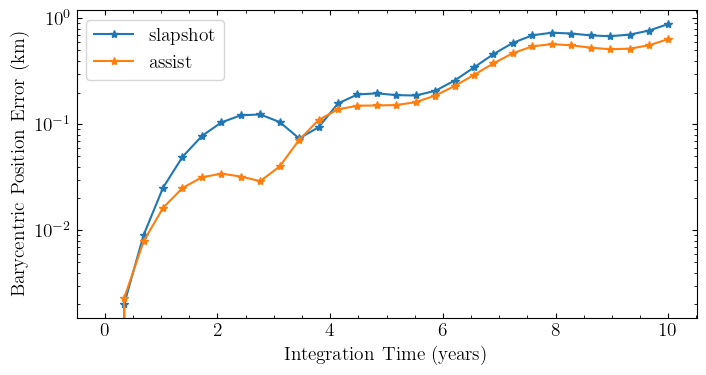

In [ ]:
import rebound
import assist
from astropy.utils.data import download_file

assist_ephemeris = ("https://ssd.jpl.nasa.gov/ftp/eph/planets/Linux/de441/linux_m13000p17000.441")
assist_asteroid = ("https://ssd.jpl.nasa.gov/ftp/eph/small_bodies/asteroids_de441/sb441-n16.bsp")

ephem = assist.Ephem(
    download_file(assist_ephemeris, cache=True),
    download_file(assist_asteroid, cache=True),
)

sim = rebound.Simulation()
ex = assist.Extras(sim, ephem)

sim.add(
    x=true_x0[0],
    y=true_x0[1],
    z=true_x0[2],
    vx=true_v0[0],
    vy=true_v0[1],
    vz=true_v0[2],
)
sim.t = times[0].tdb.jd - ephem.jd_ref

assist_xs = []
assist_vs = []
for t in times:
    sim.integrate(t.tdb.jd - ephem.jd_ref)
    assist_xs.append(jnp.array([sim.particles[0].x, sim.particles[0].y, sim.particles[0].z]))
    assist_vs.append(jnp.array([sim.particles[0].vx, sim.particles[0].vy, sim.particles[0].vz]))

assist_xs = jnp.array(assist_xs)
assist_vs = jnp.array(assist_vs)

assist_discrepency = jnp.linalg.norm(assist_xs - horizons_vecs, axis=1) * u.au.to(u.km)


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((times.tdb.jd - times.tdb.jd[0])*u.day.to(u.year), discrepency, marker='*', label='jorbit')
ax.plot((times.tdb.jd - times.tdb.jd[0])*u.day.to(u.year), assist_discrepency, marker='*', label='assist')
ax.set(yscale='log', xlabel='Integration Time (years)', ylabel='Barycentric Position Error (km)');
ax.legend();

Though `ASSIST` slightly outperforms `jorbit` (especially at early times) their behaviors are qualitatively similar and both diverge from Horizons at roughly the same rate. As of writing, ASSIST does not natively convert from 3D positions to astrometry, though we see above that both achieve < 1 mas errors compared to Horizons predictions on decade-long timescales.

### Out-and-back integrations
---

In [12]:
from jorbit.data import all_planets, large_asteroids

deltas = 10**jnp.linspace(-2, 4.5, 50)*u.day
GR_errors = []

for delta in deltas:
    if delta < 20*u.year:
        asteroid = Particle(
            x=true_x0,
            v=true_v0,
            gm=0,
            time=Time('2023-01-01'),
            planet_perturbers=all_planets,
            asteroid_perturbers=large_asteroids,
            earliest_time=Time('2020-01-01'),
            latest_time=Time('2050-01-01'),
            name='(274301) Wikipedia',
    )
        asteroid.propagate(Time('2023-01-01') + delta, use_GR=True)
        asteroid.propagate(Time('2023-01-01'), use_GR=True)
    
    else:
        asteroid = Particle(
            x=true_x0,
            v=true_v0,
            gm=0,
            time=Time('2023-01-01'),
            planet_perturbers=all_planets,
            asteroid_perturbers=large_asteroids,
            earliest_time=Time('2020-01-01'),
            latest_time=Time('2200-01-01'),
            name='(274301) Wikipedia',
    )
        asteroid.propagate(Time('2023-01-01') + delta, use_GR=True, obey_large_step_limits=False)
        asteroid.propagate(Time('2023-01-01'), use_GR=True, obey_large_step_limits=False)    
    
    GR_errors.append(jnp.linalg.norm((asteroid.x - true_x0)*u.au.to(u.m)))
GR_errors = jnp.array(GR_errors)

TypeError: __init__() got an unexpected keyword argument 'planet_perturbers'

In [ ]:
deltas = 10**jnp.linspace(-2, 4.5, 50)*u.day
newtonian_errors = []

for delta in deltas:
    if delta < 20*u.year:
        asteroid = Particle(
            x=true_x0,
            v=true_v0,
            gm=0,
            time=Time('2023-01-01'),
            planet_perturbers=all_planets,
            asteroid_perturbers=large_asteroids,
            earliest_time=Time('2020-01-01'),
            latest_time=Time('2050-01-01'),
            name='(274301) Wikipedia',
    )
        asteroid.propagate(Time('2023-01-01') + delta, use_GR=False)
        asteroid.propagate(Time('2023-01-01'), use_GR=False)
    
    else:
        asteroid = Particle(
            x=true_x0,
            v=true_v0,
            gm=0,
            time=Time('2023-01-01'),
            planet_perturbers=all_planets,
            asteroid_perturbers=large_asteroids,
            earliest_time=Time('2020-01-01'),
            latest_time=Time('2200-01-01'),
            name='(274301) Wikipedia',
    )
        asteroid.propagate(Time('2023-01-01') + delta, use_GR=False, obey_large_step_limits=False)
        asteroid.propagate(Time('2023-01-01'), use_GR=False, obey_large_step_limits=False)    
    
    newtonian_errors.append(jnp.linalg.norm((asteroid.x - true_x0)*u.au.to(u.m)))
newtonian_errors = jnp.array(newtonian_errors)

In [ ]:
assist_ephemeris = ("https://ssd.jpl.nasa.gov/ftp/eph/planets/Linux/de441/linux_m13000p17000.441")
assist_asteroid = ("https://ssd.jpl.nasa.gov/ftp/eph/small_bodies/asteroids_de441/sb441-n16.bsp")

ephem = assist.Ephem(
    download_file(assist_ephemeris, cache=True),
    download_file(assist_asteroid, cache=True),
)

assist_errors = []
for delta in deltas:
    sim = rebound.Simulation()
    ex = assist.Extras(sim, ephem)

    sim.add(
        x=true_x0[0],
        y=true_x0[1],
        z=true_x0[2],
        vx=true_v0[0],
        vy=true_v0[1],
        vz=true_v0[2],
    )
    sim.t = Time('2023-01-01').tdb.jd - ephem.jd_ref

    sim.integrate((Time('2023-01-01')+ delta).tdb.jd - ephem.jd_ref)
    sim.integrate(Time('2023-01-01').tdb.jd - ephem.jd_ref)
    assist_errors.append(jnp.linalg.norm((jnp.array([sim.particles[0].x, sim.particles[0].y, sim.particles[0].z]) - true_x0)*u.au.to(u.m)))

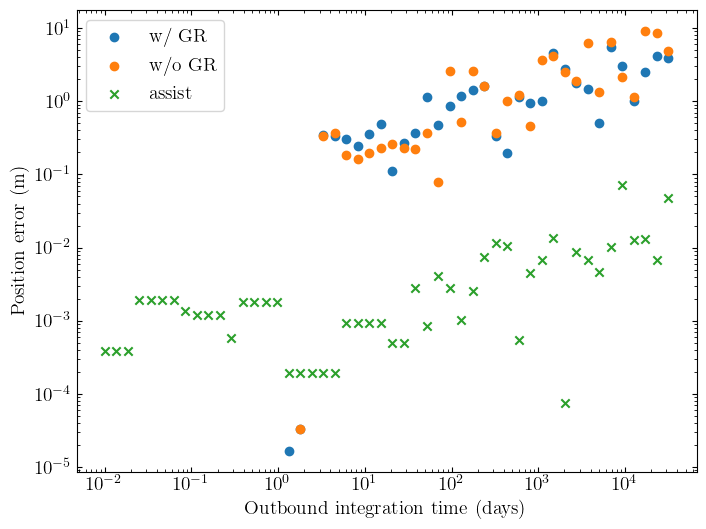

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(10**jnp.linspace(-2, 4.5, 50), GR_errors, label='w/ GR')
ax.scatter(10**jnp.linspace(-2, 4.5, 50), newtonian_errors, label='w/o GR')
ax.scatter(10**jnp.linspace(-2, 4.5, 50), assist_errors, marker='x', label='assist')
ax.set(xscale='log', yscale='log', ylabel='Position error (m)', xlabel='Outbound integration time (days)');
# ax.plot(jnp.linspace(10**-2, 10**4.5, 100), jnp.linspace(10**-2, 10**4.5, 100)**(3/2)')
ax.legend();